# Importing Libraries 📦


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img
import matplotlib.pyplot as plt

# 🗂️ Data Paths

In [ ]:
train_dir = '/content/drive/MyDrive/data/train/'
test_dir = '/content/drive/MyDrive/data/test/'

In [ ]:
def count_total_images(path):
    total_images = 0
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        total_images += len(os.listdir(dir_))
    return total_images

train_total = count_total_images(train_dir)
test_total = count_total_images(test_dir)

total_images = train_total + test_total

train_percentage = (train_total / total_images) * 100
test_percentage = (test_total / total_images) * 100

print(f"Total images: {total_images}")
print(f"Training set: {train_total} images, {train_percentage:.2f}% of the total data")
print(f"Test set: {test_total} images, {test_percentage:.2f}% of the total data")

Total images: 35887
Training set: 28709 images, 80.00% of the total data
Test set: 7178 images, 20.00% of the total data


In [ ]:

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)


       fear   sad  surprise  angry  neutral  disgust  happy
train  4097  4830      3171   3995     4965      436   7215
       sad  surprise  neutral  fear  disgust  angry  happy
test  1247       831     1233  1024      111    958   1774


<Axes: >

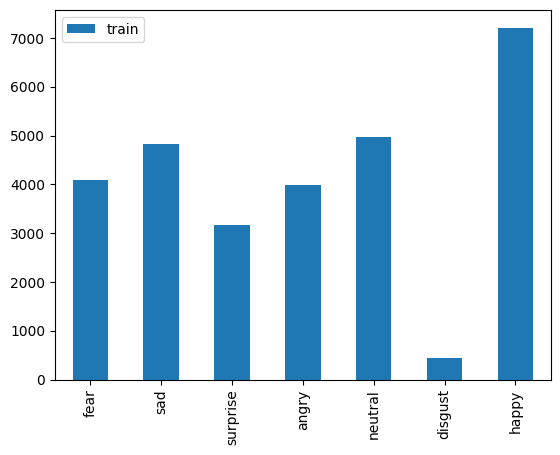

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

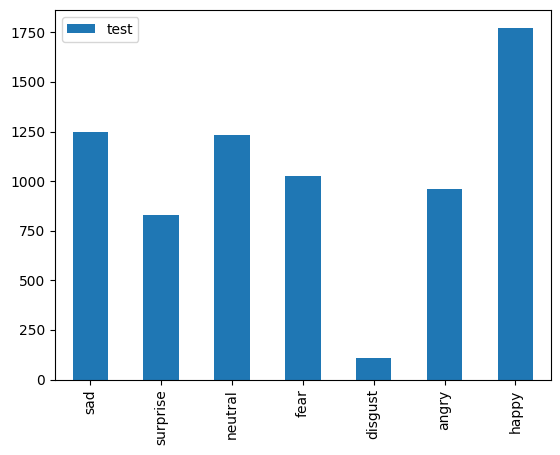

In [ ]:
test_count.transpose().plot(kind='bar')

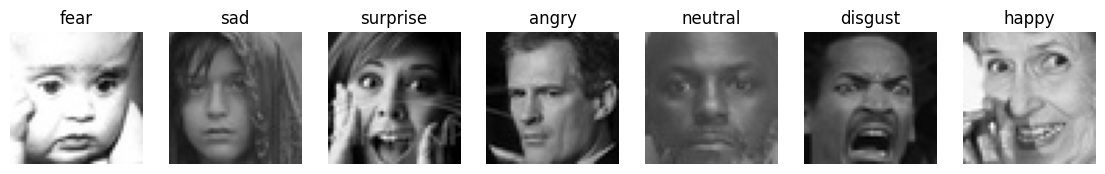

In [ ]:
plt.figure(figsize=(14, 22))
i = 1

for expression in os.listdir(train_dir):
    image_path = os.path.join(train_dir, expression, os.listdir(os.path.join(train_dir, expression))[0])
    img = load_img(image_path)

    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

#🔄 Data Preprocessing

In [ ]:

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    subset='validation'
)


Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.


In [ ]:

def get_class_distribution(generator):
    class_indices = generator.class_indices
    class_distribution = pd.Series(generator.classes).value_counts().sort_index()
    return class_indices, class_distribution

train_class_indices, train_class_distribution = get_class_distribution(train_generator)

val_class_indices, val_class_distribution = get_class_distribution(validation_generator)

train_class_df = pd.DataFrame({"Class": list(train_class_indices.keys()), "Count": train_class_distribution.values})
print("Répartition des images par classe pour l'entraînement :")
print(train_class_df)

val_class_df = pd.DataFrame({"Class": list(val_class_indices.keys()), "Count": val_class_distribution.values})
print("Répartition des images par classe pour la validation :")
print(val_class_df)


Répartition des images par classe pour l'entraînement :
      Class  Count
0     angry   3596
1   disgust    393
2      fear   3688
3     happy   6494
4   neutral   4469
5       sad   4347
6  surprise   2854
Répartition des images par classe pour la validation :
      Class  Count
0     angry    399
1   disgust     43
2      fear    409
3     happy    721
4   neutral    496
5       sad    483
6  surprise    317


In [ ]:
data_gentest = ImageDataGenerator(rescale=1./255)
test_generator = data_gentest.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False ,
)

Found 7178 images belonging to 7 classes.


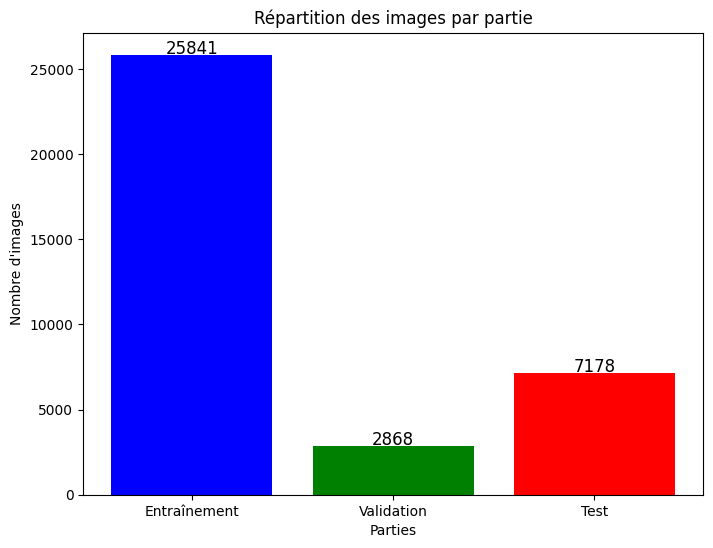

In [ ]:

train_count = train_generator.samples
validation_count = validation_generator.samples
test_count = test_generator.samples

labels = ['Entraînement', 'Validation', 'Test']
counts = [train_count, validation_count, test_count]
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'green', 'red'])

plt.title('Répartition des images par partie')
plt.xlabel('Parties')
plt.ylabel('Nombre d\'images')

for i in range(len(counts)):
    plt.text(i, counts[i] + 50, str(counts[i]), ha='center', fontsize=12)

plt.show()


# 🧠 Model Building

In [ ]:
from tensorflow.keras.models import Sequential

emotion_model=Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))
emotion_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt = Adam(learning_rate = 0.0001)
emotion_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
emotion_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import  EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Model Training

In [ ]:

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

hist = emotion_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]

)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


403/403 ━━━━━━━━━━━━━━━━━━━━ 8671s 21s/step - accuracy: 0.2455 - loss: 1.8297 - val_accuracy: 0.3089 - val_loss: 1.7366
Epoch 2/50
  1/403 ━━━━━━━━━━━━━━━━━━━━ 5:38 841ms/step - accuracy: 0.3125 - loss: 1.7097

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


403/403 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.3125 - loss: 1.7097 - val_accuracy: 0.2500 - val_loss: 1.6968
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.3301 - loss: 1.6874 - val_accuracy: 0.4116 - val_loss: 1.5638
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 498us/step - accuracy: 0.3750 - loss: 1.5697 - val_accuracy: 0.4423 - val_loss: 1.5867
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.4018 - loss: 1.5519 - val_accuracy: 0.4403 - val_loss: 1.4734
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step - accuracy: 0.5000 - loss: 1.3264 - val_accuracy: 0.5192 - val_loss: 1.2691
Epoch 7/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.4367 - loss: 1.4643 - val_accuracy: 0.4648 - val_loss: 1.4184
Epoch 8/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5156 - loss: 1.4970 - val_accuracy: 0.5769 - val_loss: 1.2284
Epoch 9/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.4648 - loss: 1.4019 - val_accuracy: 0.4

# 📈 Visualization of Training Results

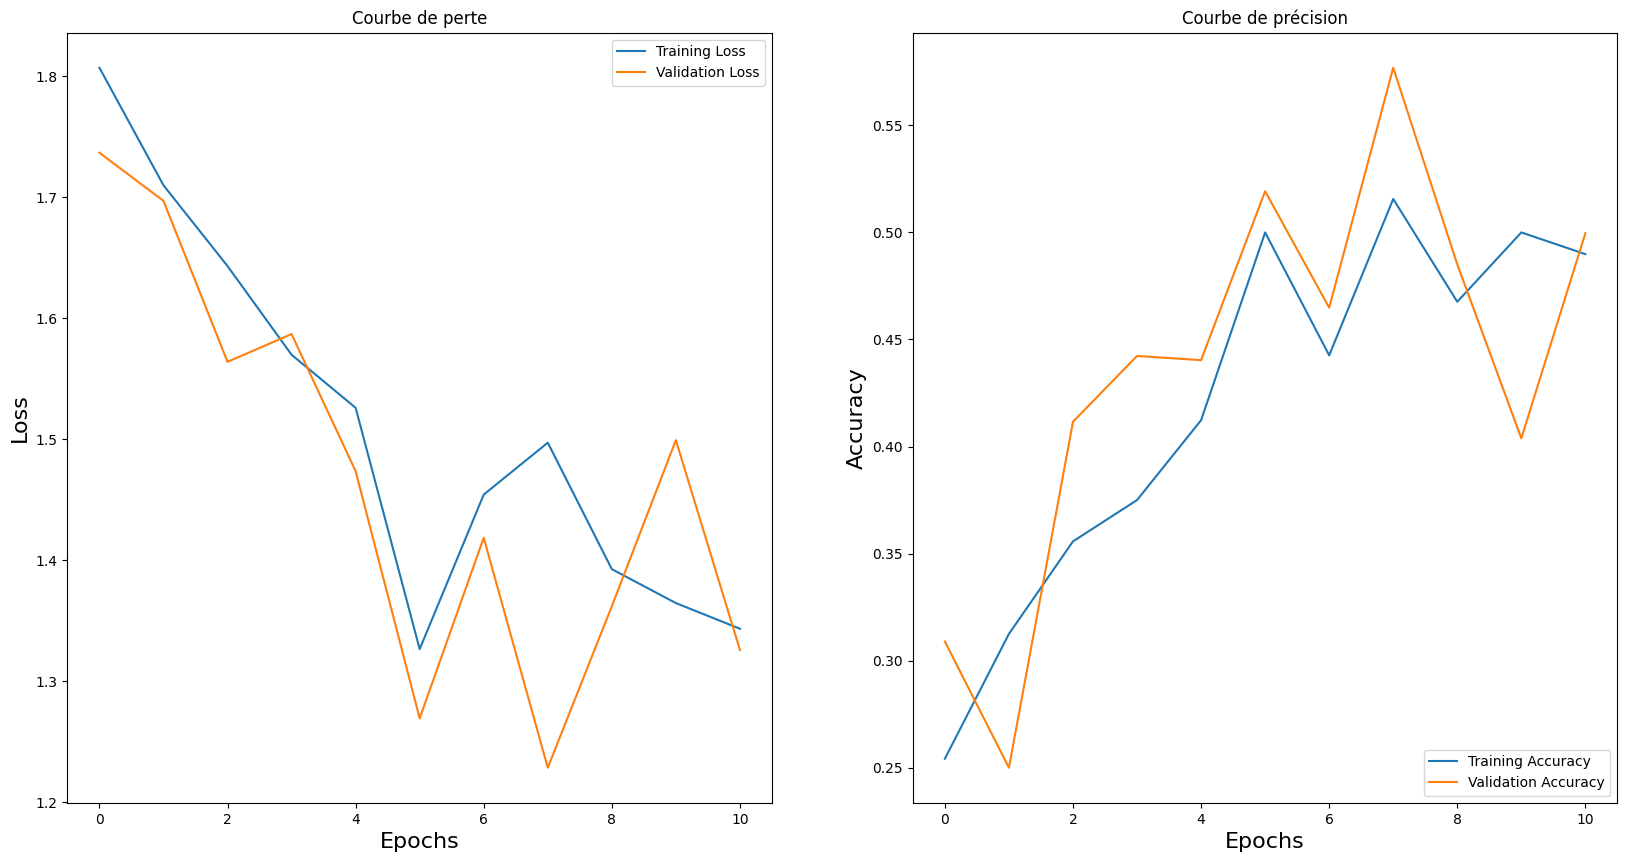

In [ ]:

plt.figure(figsize=(20, 10))


plt.subplot(1, 2, 1)
plt.title('Courbe de perte')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title('Courbe de précision')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()


# 📊 Model Evaluation

In [ ]:
Y_pred = emotion_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)

y_pred = np.argmax(Y_pred, axis=1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 2065s 19s/step


In [ ]:
len(y_pred)


7168

In [ ]:
test_generator.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
y_true = test_generator.classes


In [ ]:
if len(y_pred) < len(y_true):
    y_true = y_true[:len(y_pred)]

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.37      0.30      0.33       958
     disgust       0.00      0.00      0.00       111
        fear       0.35      0.10      0.15      1024
       happy       0.53      0.83      0.65      1774
     neutral       0.41      0.46      0.44      1233
         sad       0.39      0.29      0.33      1247
    surprise       0.53      0.65      0.59       821

    accuracy                           0.47      7168
   macro avg       0.37      0.38      0.36      7168
weighted avg       0.43      0.47      0.43      7168



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
loss, accuracy = emotion_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)

print(f"Perte sur les données de test: {loss}")
print(f"Précision sur les données de test: {accuracy}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 414ms/step - accuracy: 0.3816 - loss: 1.5535
Perte sur les données de test: 1.4035537242889404
Précision sur les données de test: 0.4652622640132904


In [ ]:
emotion_model.save('emotion_model.h5')
